In [1]:
#generic imports
import os
import pathlib
import random
from datetime import datetime
import time
import numpy as np
import pandas as pd
import math
import argparse
from pathlib import Path
import itertools

#import constants
from epi_to_express.constants import (
    CHROM_LEN, 
    CHROMOSOMES, 
    SAMPLES,
    CHROMOSOME_DATA,
    SRC_PATH,
    ASSAYS,
    DATA_PATH)

#model imports
import tensorflow as tf
#data loading imports
from epi_to_express.utils import(
    train_valid_split,
    DataGenerator)

In [2]:
#paths
SAVE_PATH = pathlib.Path("./model_results")
MOD_SAVE_PATH = pathlib.Path("./model_results/models")
PRED_PATH = pathlib.Path("./model_results/predictions")
PRED_PATH.mkdir(parents=True, exist_ok=True)

#model params
init_learning_rate = 0.001
#resolution for training assay
pred_resolution = 25
# 1 Mb of the assay will be considered for the prediction of gene expression
window_size = 100_000
batch_size = 512#256
#number of k-fold cross validation
k_fold = 5

In [3]:
#use k-fold cross-validation to retrain each model k times and hold out 
#diff chromosomes for the blind test
#get all combinations of 3 chr
comb_3 = list(itertools.combinations(CHROMOSOMES,r=3))
#we want size closest to avg chr size * 3
#this avoids gettinng chr that are too small
comb_3_size = []
for comb_i in comb_3:
    comb_3_size.append([CHROM_LEN[np.where(CHROMOSOMES==j)[0][0]] for j in comb_i])
#get dif from mean
comb_3_size = [abs(np.sum(j)-(np.mean(CHROM_LEN)*3)) for j in comb_3_size]
idx = np.argpartition(np.array(comb_3_size), k_fold).tolist()
all_blind_tests = np.array(comb_3)[idx[:k_fold]].tolist()

In [ ]:
loss_fn = tf.keras.losses.mse
losses = []
indic = 0
for assay_i in ASSAYS:
    print(assay_i)
    for cell_i in SAMPLES:
        print(cell_i)
        print("K fold:")
        for ind,blind_test_i in enumerate(all_blind_tests):
            print(blind_test_i)
            #positions not chroms
            blind_test = [np.where(CHROMOSOMES==i)[0][0] for i in blind_test_i]
            test_len = CHROM_LEN[blind_test]
            test_chrom = CHROMOSOMES[blind_test]
            #exclude runs that didn't complete
            my_file = Path(f"{MOD_SAVE_PATH}/mod_{'-'.join([cell_i])}_{'-'.join([assay_i])}_kfold{ind}")
            if my_file.exists():
                scores = []
                #load model
                model = tf.keras.models.load_model(f"{MOD_SAVE_PATH}/mod_{'-'.join([cell_i])}_{'-'.join([assay_i])}_kfold{ind}")
                #compile
                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_learning_rate),
                      loss=tf.keras.losses.mean_squared_error,
                      metrics='mse')
                #generator
                generator = DataGenerator(cell=[cell_i], 
                                  chromosomes=test_chrom,
                                  features=[assay_i], 
                                  window_size=window_size,
                                  pred_res=pred_resolution, 
                                  batch_size=batch_size,
                                  shuffle=False)
                for ind in range(len(generator)):
                    #get data
                    X,y = generator[ind]
                    #predict
                    output = model.predict(X)
                    #eval
                    evalu = loss_fn(y, output[:,0,0])
                    scores.append(evalu)
                #keep all res in a list index is assay-cell
                scores = np.concatenate([score.numpy() for score in scores], axis=0)
                scores = [item for sublist in scores.tolist() for item in sublist]
                losses.append(pd.DataFrame({"assay":[assay_i]*len(scores),
                                            "cell":[cell_i]*len(scores),
                                            "mse":scores}))

h3k36me3
H1 Cell Line
K fold:
['chr2', 'chr16', 'chr19']


2022-07-05 18:46:53.848285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 18:46:53.857439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 18:46:53.858345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 18:46:53.859845: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

['chr3', 'chr10', 'chr19']
['chr5', 'chr12', 'chr18']
['chr3', 'chr8', 'chr21']
['chr6', 'chr7', 'chr20']
A549
K fold:
['chr2', 'chr16', 'chr19']
['chr3', 'chr10', 'chr19']
['chr5', 'chr12', 'chr18']
['chr3', 'chr8', 'chr21']
['chr6', 'chr7', 'chr20']
GM12878
K fold:
['chr2', 'chr16', 'chr19']
['chr3', 'chr10', 'chr19']
['chr5', 'chr12', 'chr18']
['chr3', 'chr8', 'chr21']
['chr6', 'chr7', 'chr20']
HELA
K fold:
['chr2', 'chr16', 'chr19']
['chr3', 'chr10', 'chr19']
['chr5', 'chr12', 'chr18']
['chr3', 'chr8', 'chr21']
['chr6', 'chr7', 'chr20']
HEPG2
K fold:
['chr2', 'chr16', 'chr19']
['chr3', 'chr10', 'chr19']
['chr5', 'chr12', 'chr18']
['chr3', 'chr8', 'chr21']
['chr6', 'chr7', 'chr20']
HMEC
K fold:
['chr2', 'chr16', 'chr19']
['chr3', 'chr10', 'chr19']
['chr5', 'chr12', 'chr18']
['chr3', 'chr8', 'chr21']
['chr6', 'chr7', 'chr20']
HSMM
K fold:
['chr2', 'chr16', 'chr19']
['chr3', 'chr10', 'chr19']
['chr5', 'chr12', 'chr18']
['chr3', 'chr8', 'chr21']
['chr6', 'chr7', 'chr20']
HUVEC
K fold:


['chr3', 'chr8', 'chr21']
['chr6', 'chr7', 'chr20']
HSMM
K fold:
['chr2', 'chr16', 'chr19']
['chr3', 'chr10', 'chr19']
['chr5', 'chr12', 'chr18']
['chr3', 'chr8', 'chr21']
['chr6', 'chr7', 'chr20']
HUVEC
K fold:
['chr2', 'chr16', 'chr19']
['chr3', 'chr10', 'chr19']
['chr5', 'chr12', 'chr18']
['chr3', 'chr8', 'chr21']
['chr6', 'chr7', 'chr20']
K562
K fold:
['chr2', 'chr16', 'chr19']
['chr3', 'chr10', 'chr19']
['chr5', 'chr12', 'chr18']
['chr3', 'chr8', 'chr21']
['chr6', 'chr7', 'chr20']
NHEK
K fold:
['chr2', 'chr16', 'chr19']
['chr3', 'chr10', 'chr19']
['chr5', 'chr12', 'chr18']
['chr3', 'chr8', 'chr21']
['chr6', 'chr7', 'chr20']
dnase
H1 Cell Line
K fold:
['chr2', 'chr16', 'chr19']
['chr3', 'chr10', 'chr19']
['chr5', 'chr12', 'chr18']
['chr3', 'chr8', 'chr21']
['chr6', 'chr7', 'chr20']
A549
K fold:
['chr2', 'chr16', 'chr19']
['chr3', 'chr10', 'chr19']
['chr5', 'chr12', 'chr18']
['chr3', 'chr8', 'chr21']
['chr6', 'chr7', 'chr20']
GM12878
K fold:
['chr2', 'chr16', 'chr19']
['chr3', 'chr1

In [ ]:
#concat to single dataframe
losses = pd.concat(losses)
#save res
losses.to_csv(f"{PRED_PATH}/blind_test.csv", sep='\t',index=False)

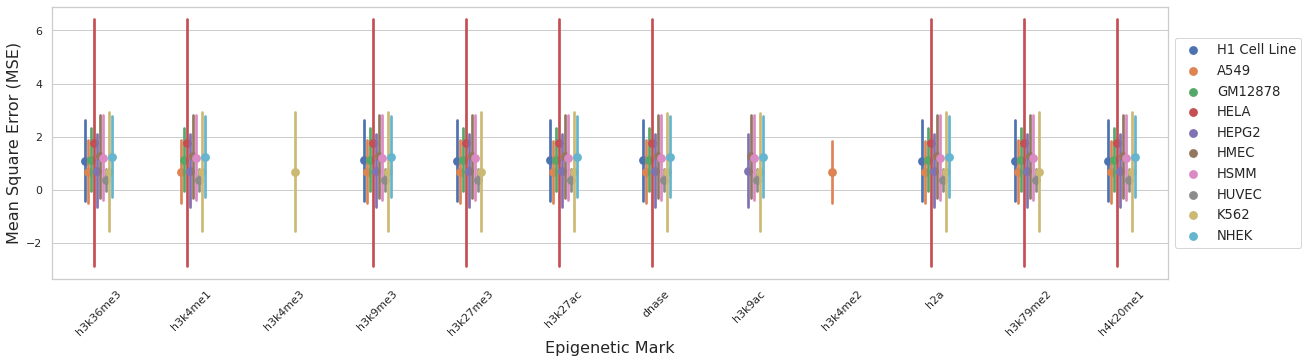

In [6]:
#plot
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 5)})
#sns.set_palette("colorblind")
#same wesanderson palette as used in R plots
extended_palette = ["#9A8822","#F5CDB4","#F8AFA8",
                    "#FDDDA0","#74A089","#85D4E3",
                    #added extra to make 7
                    '#78A2CC']
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

perf_plt = sns.pointplot(hue = "cell",       
            y = "mse",
            x = "assay",  
            #palette=sns.color_palette(extended_palette, 7)[2:4],
            data = losses, ci="sd",join=False,
            dodge=0.3
                      )
#perf_plt.set_title('MSE',fontsize=14)
#perf_plt.legend([],[], frameon=False)
# Put the legend out of the figure
perf_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#perf_plt.set(ylim=(-.1, .9))
perf_plt.tick_params(axis='x', rotation=45)

perf_plt.set_xlabel('Epigenetic Mark',fontsize=16)
perf_plt.set_ylabel('Mean Square Error (MSE)',fontsize=16)
perf_plt.tick_params(labelsize=11)

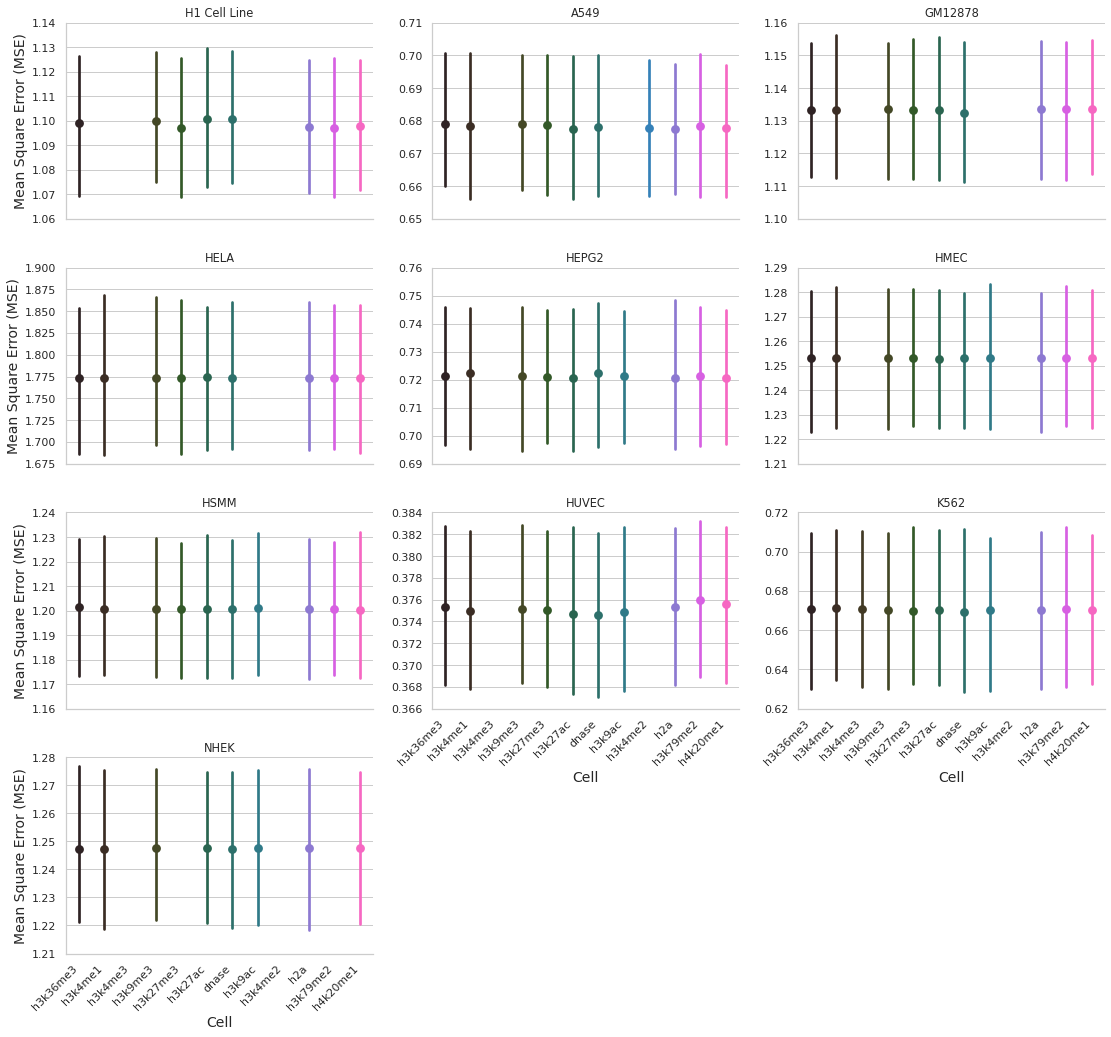

In [7]:
#plot
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 5)})
sns.set_palette("colorblind")
sns.set(font_scale = 0.95)
sns.set_style("whitegrid")

perf_plt = sns.FacetGrid(losses, col = "cell", hue="assay",col_wrap=3,
                         sharey=False, sharex=True, margin_titles=True,
                         height=3.5, aspect=1.5)
perf_plt = perf_plt.map(sns.pointplot,"assay","mse","assay",
                        order=losses['assay'].explode().unique(),
                        hue_order=losses['assay'].explode().unique())
                        #ci="sd",join=False,dodge=0.3)
#perf_plt.set_title('MSE',fontsize=14)
#perf_plt.legend([],[], frameon=False)
# Put the legend out of the figure
#perf_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#perf_plt.set(ylim=(-.1, .9))
perf_plt.set_xticklabels(rotation=45,fontsize=11,ha='right')
perf_plt.set_yticklabels(fontsize=11)
perf_plt.set_titles(col_template="{col_name}")

perf_plt.set_axis_labels(x_var='Cell', y_var='Mean Square Error (MSE)',fontsize=14)
#perf_plt.tick_params(labelsize=11)

In [ ]:
np.mean([losses.loc[(losses['assay'] == "h3k36me3") & (losses['cell'] == "GM12878")]['mse']-losses.loc[(losses['assay'] == "h3k27ac") & (losses['cell'] == "GM12878")]["mse"]])

In [ ]:
np.mean([losses.loc[(losses['assay'] == "h3k36me3") & (losses['cell'] == "GM12878")]['mse']-losses.loc[(losses['assay'] == "h3k27ac") & (losses['cell'] == "GM12878")]["mse"]])

In [ ]:
sns.pointplot(hue = "cell",       
            y = "mse",
            x = "assay",  
            #palette=sns.color_palette(extended_palette, 7)[2:4],
            data = losses.loc[(losses['assay'] == "h3k27ac") & (losses['cell'] == "GM12878")], ci="sd",join=False,
            dodge=0.3
                      )

